In [1]:
import pickle
from flask import Flask , request , Blueprint
from flask_cors import CORS 
from flask_pymongo import pymongo
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import datetime
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import base64
from io import BytesIO


In [2]:
def create_new_dataset(file, yearOffset):

        dt = datetime.datetime(2018, 1, 1)
        end = datetime.datetime(2018 + yearOffset, 12, 30, 23, 59, 59)
        step = datetime.timedelta(days=1)

        result = []

        while dt < end:
            result.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
            dt += step
            
        result = pd.DataFrame(result)
        
        result.rename(columns={0: 'date'}, inplace=True)
        
        result.date = pd.to_datetime(result.date, format = "%Y-%m-%d")
        
        result = pd.DataFrame(result)

        csvFile = pd.read_csv(file)

        predictdata = csvFile.append(result,sort=False,ignore_index=True)
        
        predictdata.date = pd.to_datetime(predictdata.date, format = "%Y-%m-%d")

        return predictdata

In [3]:
yearOffset = int(input())

3


In [4]:
req=create_new_dataset("train.csv",yearOffset-1)

In [5]:
print(req)

             date  store  item  sales
0      2013-01-01    1.0   1.0   13.0
1      2013-01-02    1.0   1.0   11.0
2      2013-01-03    1.0   1.0   14.0
3      2013-01-04    1.0   1.0   13.0
4      2013-01-05    1.0   1.0   10.0
...           ...    ...   ...    ...
914090 2020-12-26    NaN   NaN    NaN
914091 2020-12-27    NaN   NaN    NaN
914092 2020-12-28    NaN   NaN    NaN
914093 2020-12-29    NaN   NaN    NaN
914094 2020-12-30    NaN   NaN    NaN

[914095 rows x 4 columns]


In [6]:
def training(csvFile, yearOffset):
        if(int(yearOffset) == 0):
            train = pd.read_csv(csvFile)
        else:
            train = csvFile
        temp = pd.DataFrame()
        temp["Date"] = 0
        l = []
        for i in train.date:
            l.append(str(i)[0:7])
        temp["Date"] = l
        
        train.date = temp.Date
        train.date = pd.to_datetime(train.date)
        grouped1 = train.groupby('date')['sales'].sum()
        
    

        grouped1= pd.DataFrame(grouped1)
        
        second = train.groupby(train.date.dt.year)['sales'].mean().reset_index()
        
        second.date = pd.to_datetime(second.date, format='%Y')
        
    
        grouped1.sales[grouped1.sales==0.0] = np.NaN
        
        sar = sm.tsa.statespace.SARIMAX(grouped1.sales, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()
        
        start, end, dynamic = 40, 100, 7
        
        plotimage = BytesIO()

        grouped1['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic)
        
        pred_df = grouped1.forecast[start+dynamic:end]
        
        grouped1[['sales', 'forecast']].plot(color=['mediumblue', 'Red'])

        plt.savefig(plotimage , format="png")

        plt.close()

        plotimage.seek(0)

        print(plotimage)

        predictedURL = base64.b64encode(plotimage.getvalue()).decode('utf')

        returnData = {} 

        returnData["predictedimage"] = "data:image/png;base64," + predictedURL

        final_data = grouped1.to_csv()

        final_columns = [x.split(',') for x in final_data.split('\r\n')]

        final_columns = final_columns[:-1]

        returnData["resCsv"] = final_columns

        return returnData

In [7]:
data = training(req,3)

c:\users\deebi\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\deebi\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\deebi\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'predictedimage': '', 'resCsv': [['date', 'sales', 'forecast'], ['2013-01-01', '454904.0', ''], ['2013-02-01', '459417.0', ''], ['2013-03-01', '617382.0', ''], ['2013-04-01', '682274.0', ''], ['2013-05-01', '763242.0', ''], ['2013-06-01', '795597.0', ''], ['2013-07-01', '855922.0', ''], ['2013-08-01', '766761.0', ''], ['2013-09-01', '689907.0', ''], ['2013-10-01', '656587.0', ''], ['2013-11-01', '692643.0', ''], ['2013-12-01', '506607.0', ''], ['2014-01-01', '525987.0', ''], ['2014-02-01', '529117.0', ''], ['2014-03-01', '704301.0', ''], ['2014-04-01', '788914.0', ''], ['2014-05-01', '882877.0', ''], ['2014-06-01', '906842.0', ''], ['2014-07-01', '989010.0', ''], ['2014-08-01', '885596.0', ''], ['2014-09-01', '785124.0', ''], ['2014-10-01', '758883.0', ''], ['2014-11-01', '800783.0', ''], ['2014-12-01', '578048.0', ''], ['2015-01-01', '552513.0', ''], ['2015-02-01', '551317.0', ''], ['2015-03-01', '730951.0', ''], ['2015-04-01', '824467.0', ''], ['2015-05-01', '926902.0', ''], ['2015-
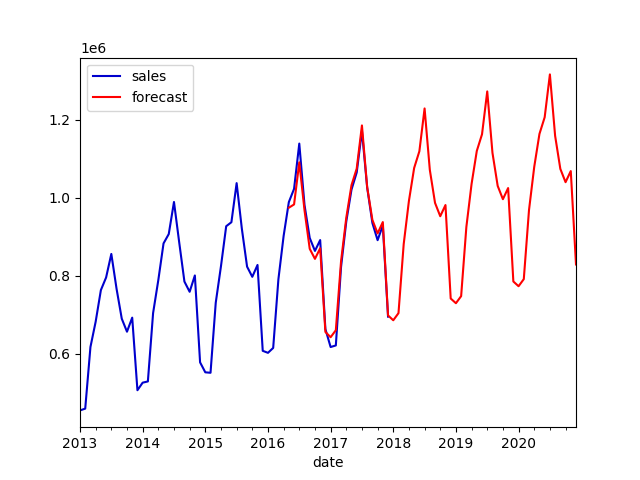

In [8]:
print(data)